# Kalman Filter, Extended Kalman Filter, and Particle Filter

## Info

Contact information:
- **Name**: Vũ Lê Thế Anh
- **Student ID**: 20C13002
- **Mail**: anh.vu2020@ict.jvn.edu.vn

Credit:
- Understanding behind the filter are from [here](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)
- Example dynamics are taken from [here](https://github.com/nicolasigor/bayesianEstimation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy.random import randn

from kalman_filter import *
from particle_filter import *

SEED = 0

## Kalman Filter

In [2]:
np.random.seed(SEED)

In [3]:
L = 20
dt = 0.1
N = int(L / dt)

T = np.linspace(0, L, N)

Initially, $z_0 = 2.5$.

For $t=1..T$,
$$
\begin{array}{lcl}
    z_t &=& 0.97 z_{t-1} + 100 u_{t-1} + w_{t-1} \\
    x_t &=& 2 z_t + v_{t}
\end{array}
$$
where $w_i, v_i$ are realizations of $W \sim \mathcal{N}(0, 0.01^2), V \sim \mathcal{N}(0, 2^2)$ and $u_t = 0.0003, \forall t=1..T$.

In [4]:
U = np.ones(N) * 0.0003

# Process model
a = np.ones(N) * 0.97
b = np.ones(N) * 100
# Process noise characterization
sw = 0.01**2

# Measurement model
c = np.ones(N) * 2
d = np.ones(N) * 0
# Measurement noise characterization
sv = 2**2

In [5]:
Z = np.zeros(N)

# True system state without noise
Z[0] = 2.5
for t in range(1, N):
    Z[t] = a[t-1] * Z[t-1] + b[t-1] * U[t-1] + randn() * np.sqrt(sw)

# Measurement without noise
X_true = c * Z + d
# Given observations
X = X_true + np.random.randn(N) * np.sqrt(sv)

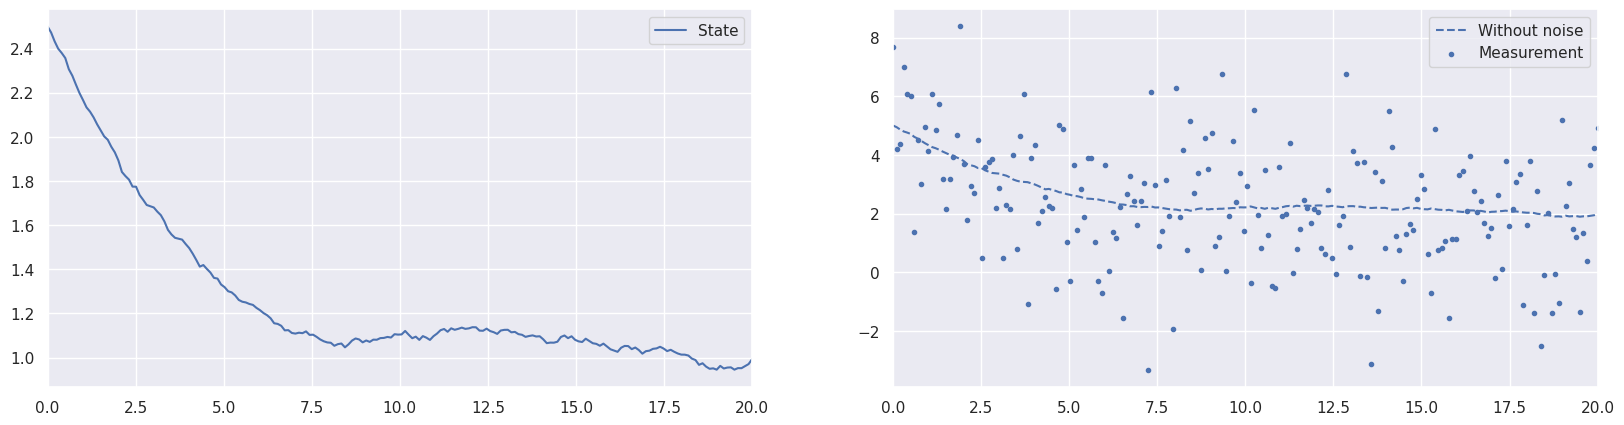

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

ax[0].plot(T, Z, label='State')
ax[0].set_xlim(0, L)
ax[0].legend()

ax[1].scatter(T, X, marker='.', label='Measurement')
ax[1].plot(T, X_true, linestyle='dashed', label='Without noise')
ax[1].set_xlim(0, L)
ax[1].legend()

plt.show()

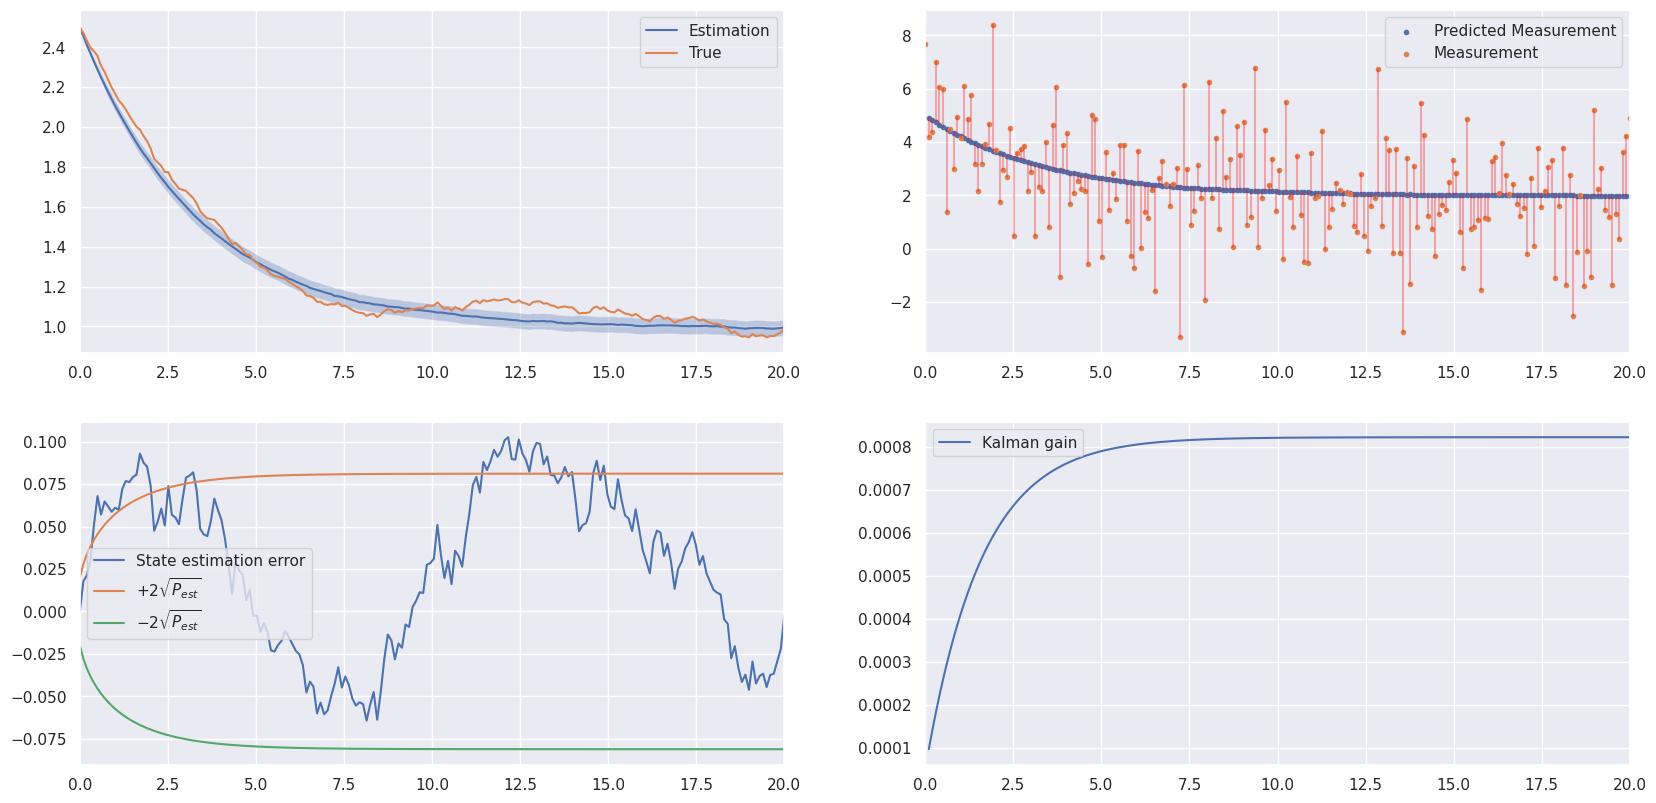

In [7]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    kalman_filter_1d(a, b, c, d, sw, sv, X, U, z0=2.5, p0=0.0001)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

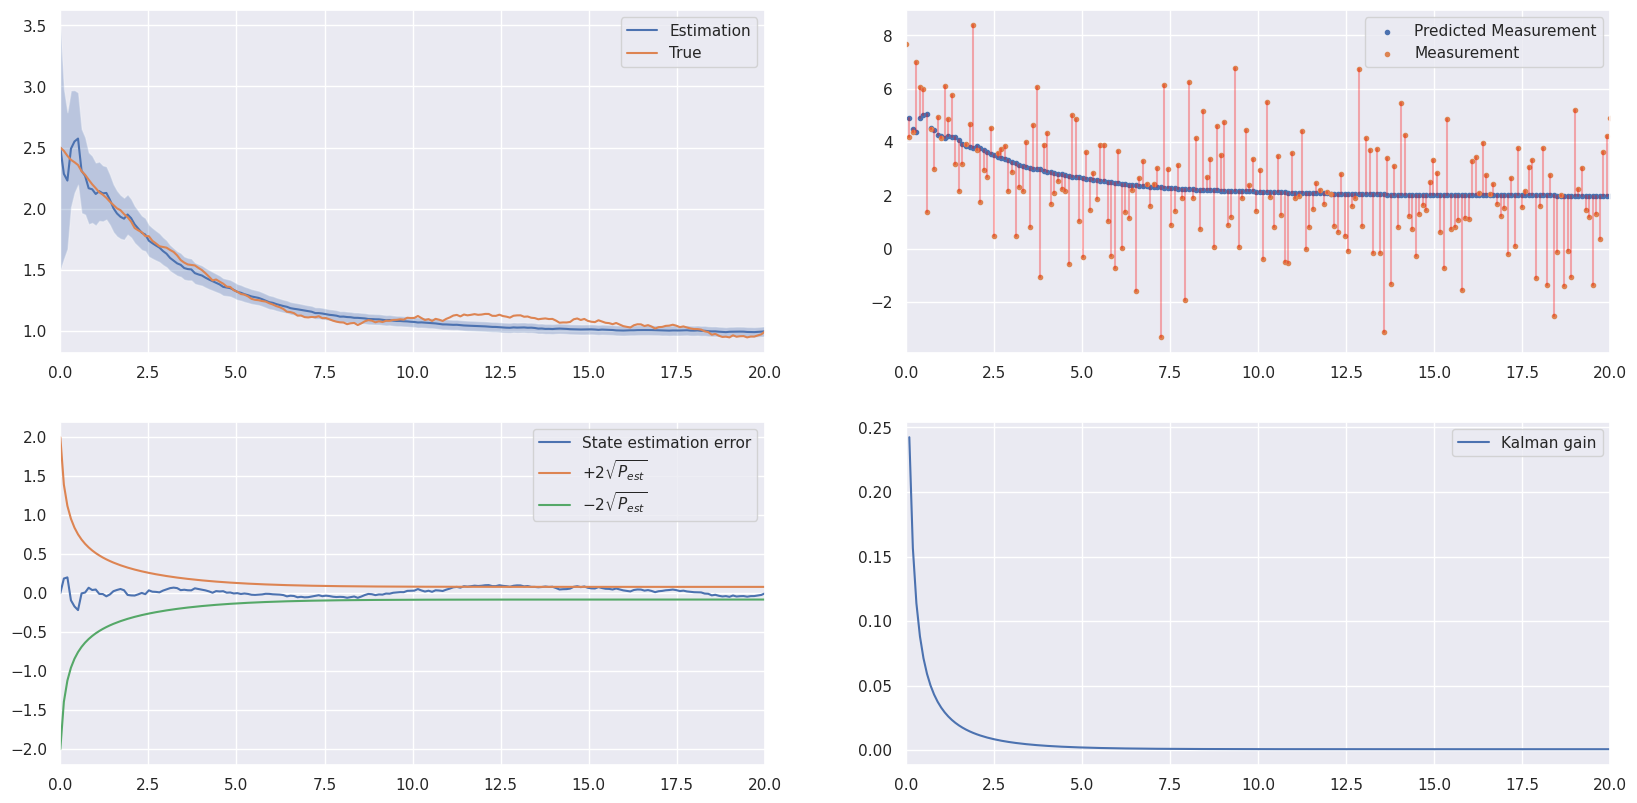

In [8]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    kalman_filter_1d(a, b, c, d, sw, sv, X, U, z0=2.5, p0=1)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

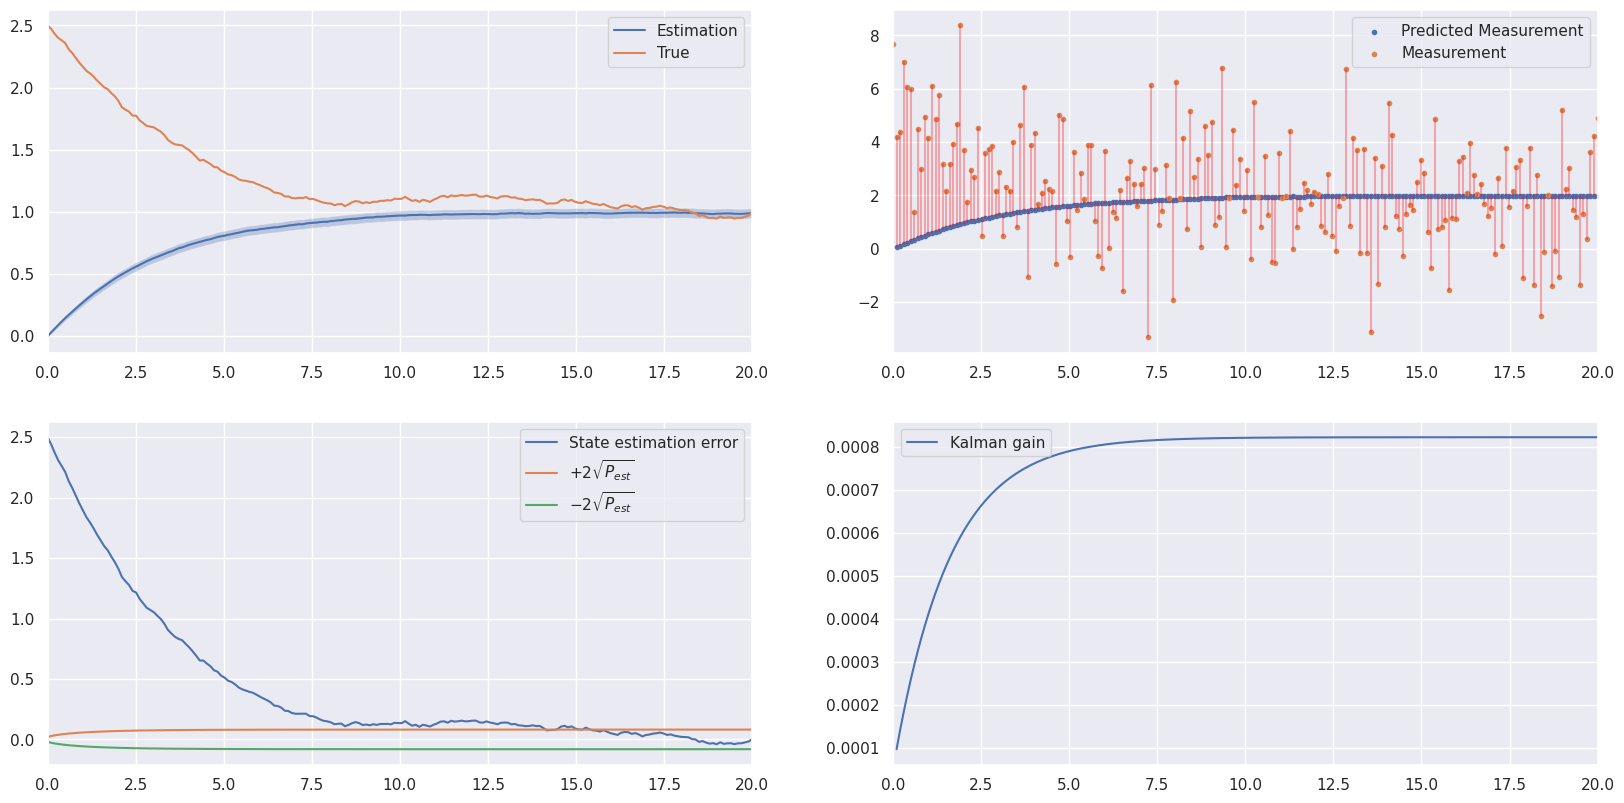

In [9]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    kalman_filter_1d(a, b, c, d, sw, sv, X, U, z0=0, p0=0.0001)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

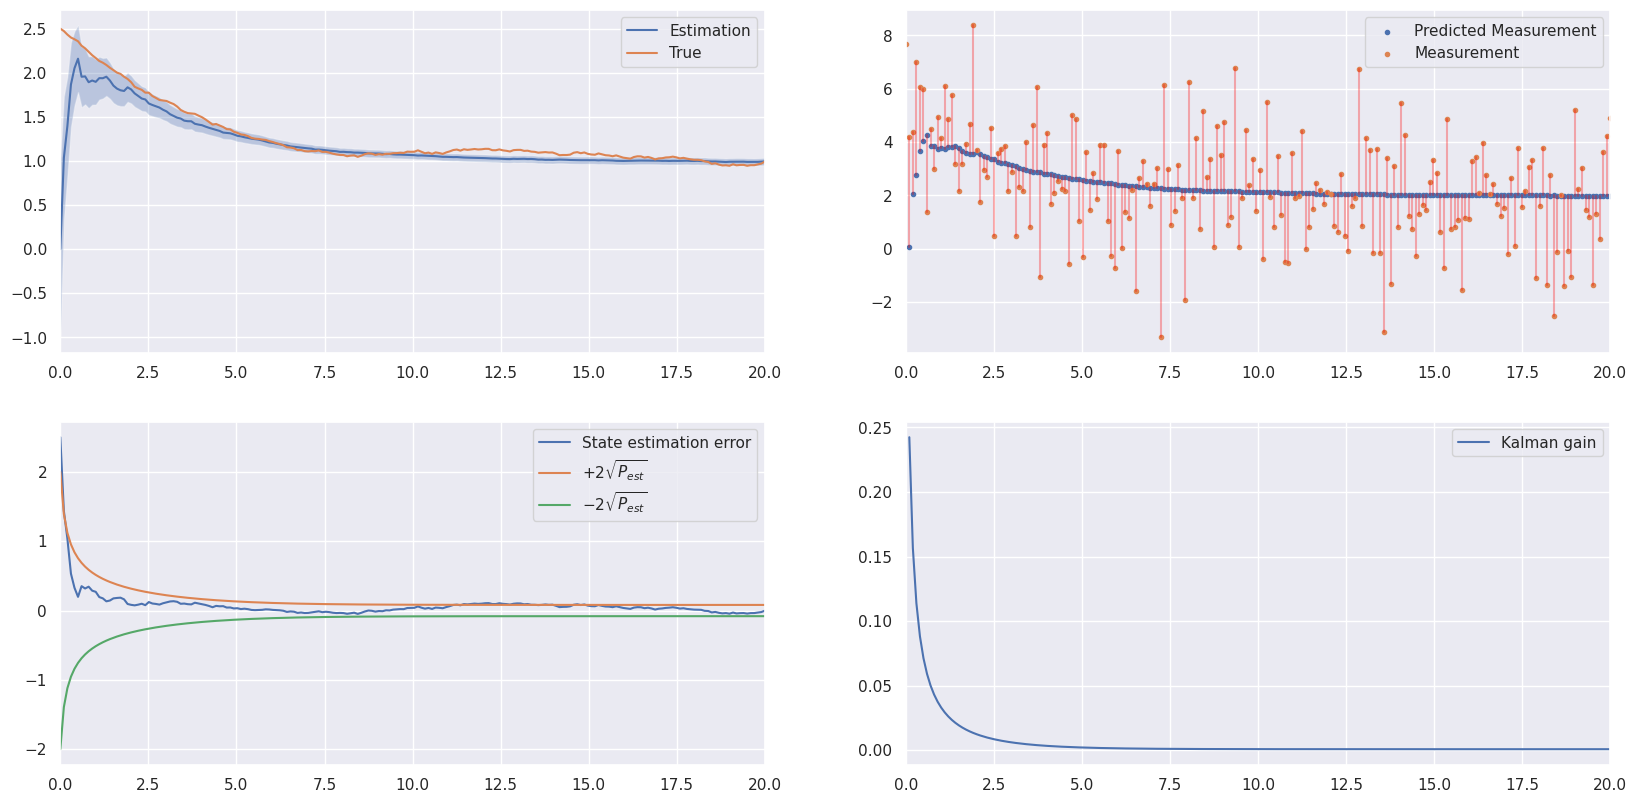

In [10]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    kalman_filter_1d(a, b, c, d, sw, sv, X, U, z0=0, p0=1)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

## Extended Kalman Filter

### Simple Non-linear

In [11]:
np.random.seed(SEED)

In [12]:
L = 1.5
dt = 0.01
N = int(L / dt)

T = np.linspace(0, L, N)

Initially, $z_0 = 2$.

For $t=1..T$,
$$
\begin{array}{lcl}
    z_t &=& 0.9995 z_{t-1} + 0.0004 z^2_{t-1} \\
    x_t &=& z^2_t + z^3_t + v_{t}
\end{array}
$$

where $v_t$ are realizations of $V \sim \mathcal{N}(0, 0.3^2)$.

In [13]:
# Process noise characterization
sw = 0.

# Measurement noise characterization
sv = 0.3**2

# Process model
def process(z_prev):
    return 0.9995 * z_prev + 0.0004 * z_prev ** 2

# Control
def control(t):
    return 0.

# Measurement model
def measurement(z_cur):
    return z_cur ** 2 + z_cur ** 3

In [14]:
Z = np.zeros(N)

# True system state without noise
Z[0] = 2.0
for t in range(1, N):
    Z[t] = process(Z[t - 1]) + randn() * np.sqrt(sw)

# Measurement without noise
X_true = measurement(Z)
# Given observations
X = X_true + randn(N) * np.sqrt(sv)

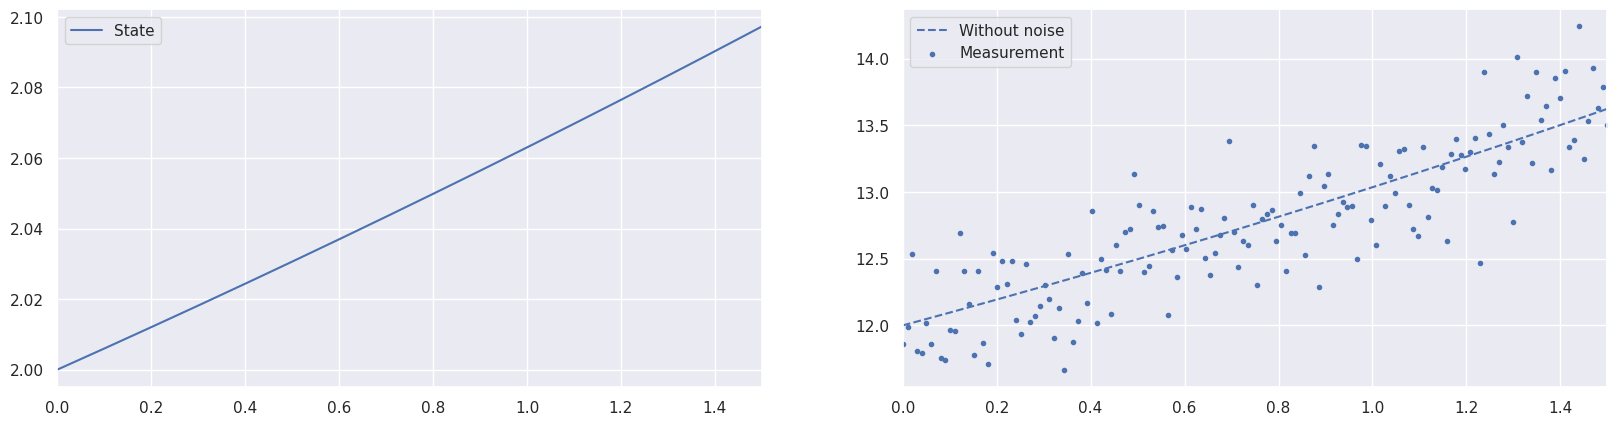

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

ax[0].plot(T, Z, label='State')
ax[0].set_xlim(0, L)
ax[0].legend()

ax[1].scatter(T, X, marker='.', label='Measurement')
ax[1].plot(T, X_true, linestyle='dashed', label='Without noise')
ax[1].set_xlim(0, L)
ax[1].legend()

plt.show()

Make the approximation
$$
\begin{array}{lcl}
    a[z_{t-1}] &=& 0.9995 + 0.0008 z_{t-1} \\
    c[z_t] &=& 2 z_t + 3 z^2_t
\end{array}
$$

In [16]:
def d_process(z_prev):
    return 0.9995 + 0.0008 * z_prev

def d_measurement(z_cur):
    return 2 * z_cur + 3 * z_cur ** 2

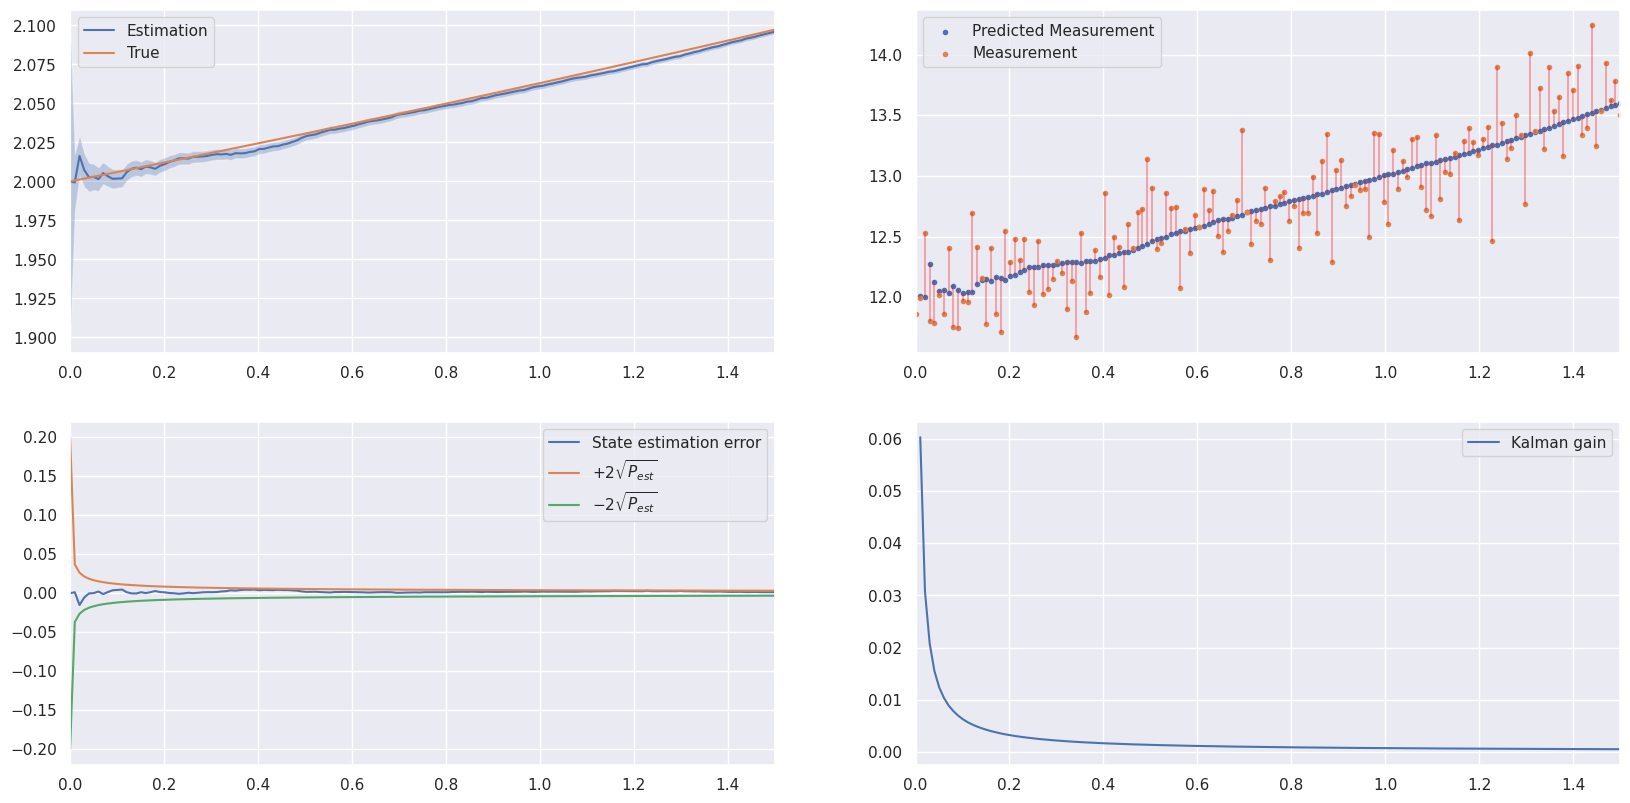

In [17]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=2, p0=0.01)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

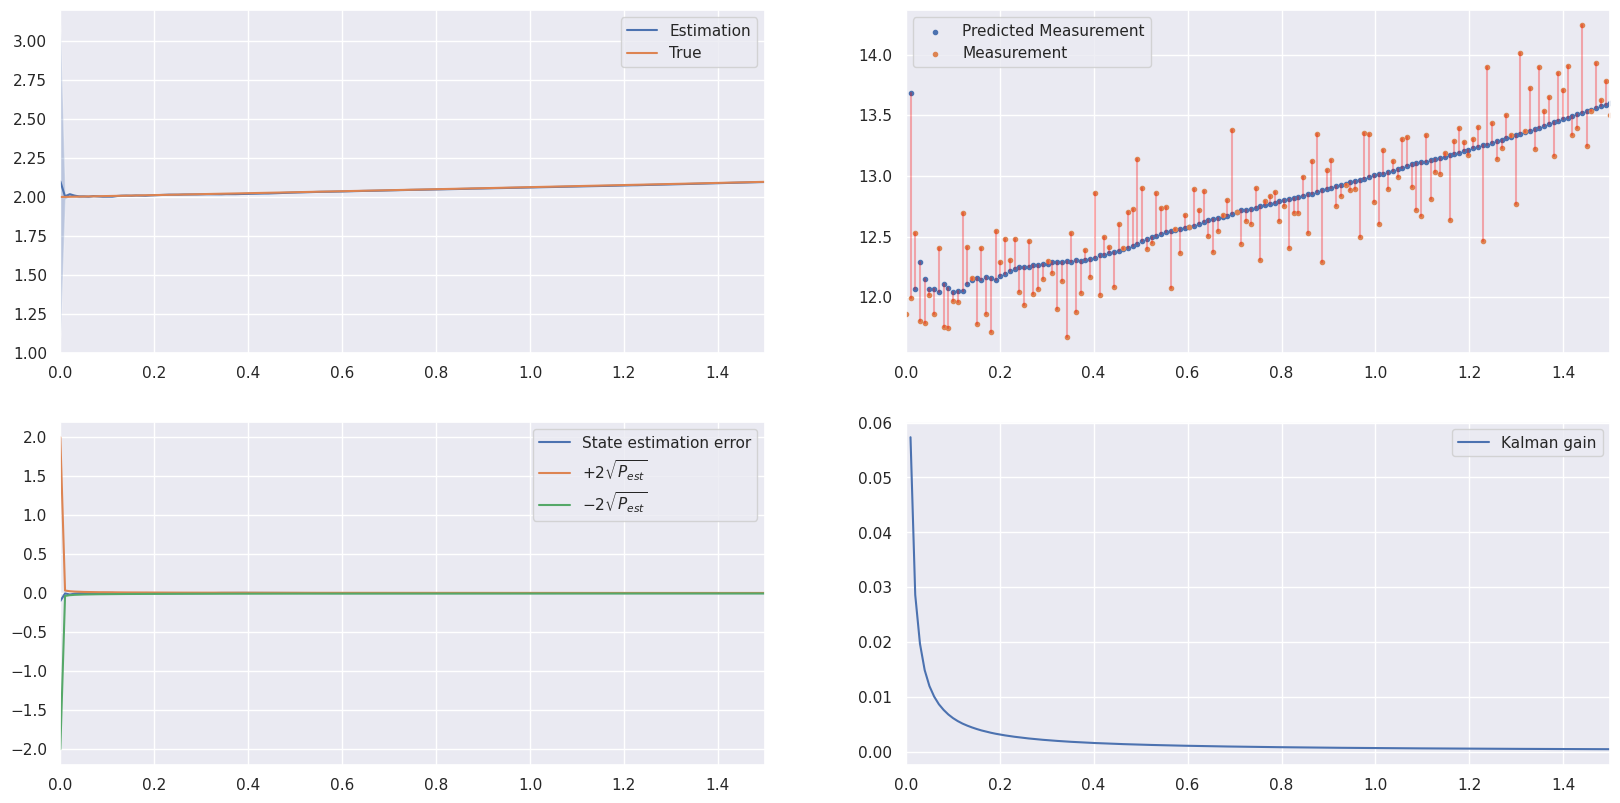

In [18]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=2.1, p0=1)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

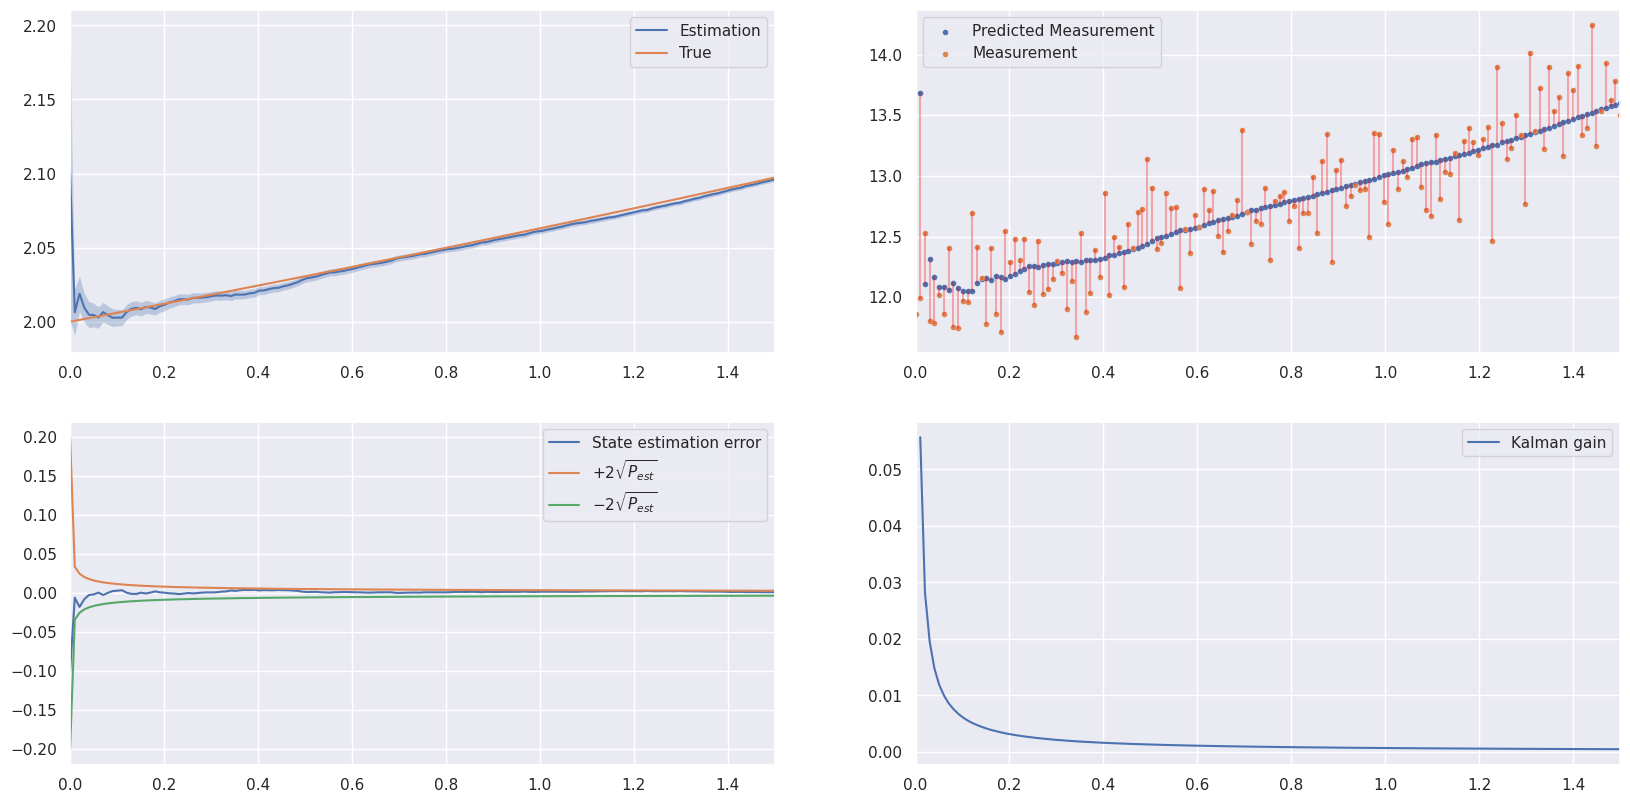

In [19]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=2.1, p0=0.01)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

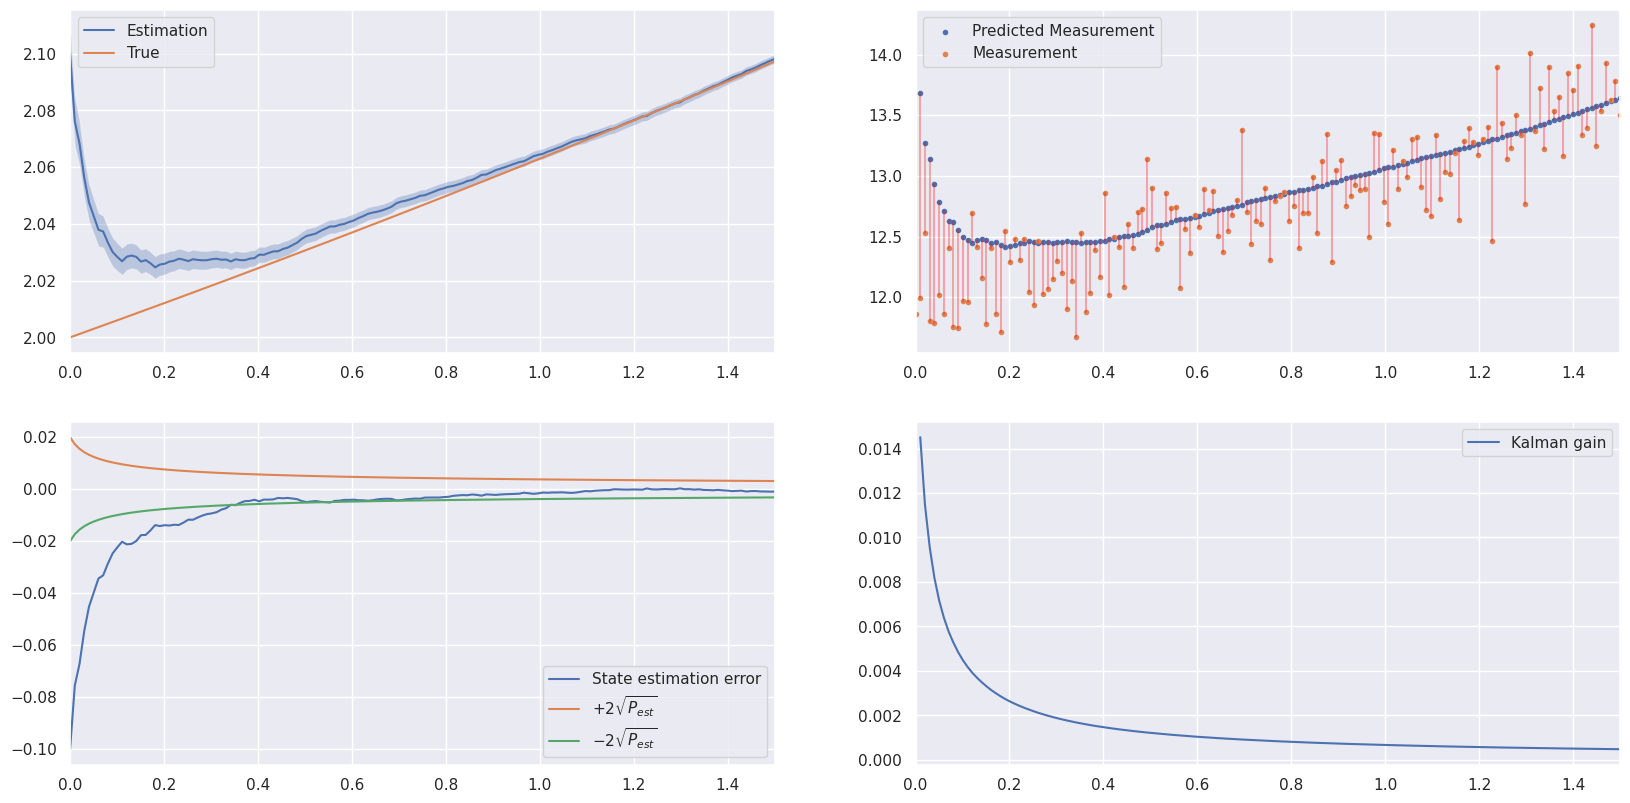

In [20]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=2.1, p0=0.0001)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

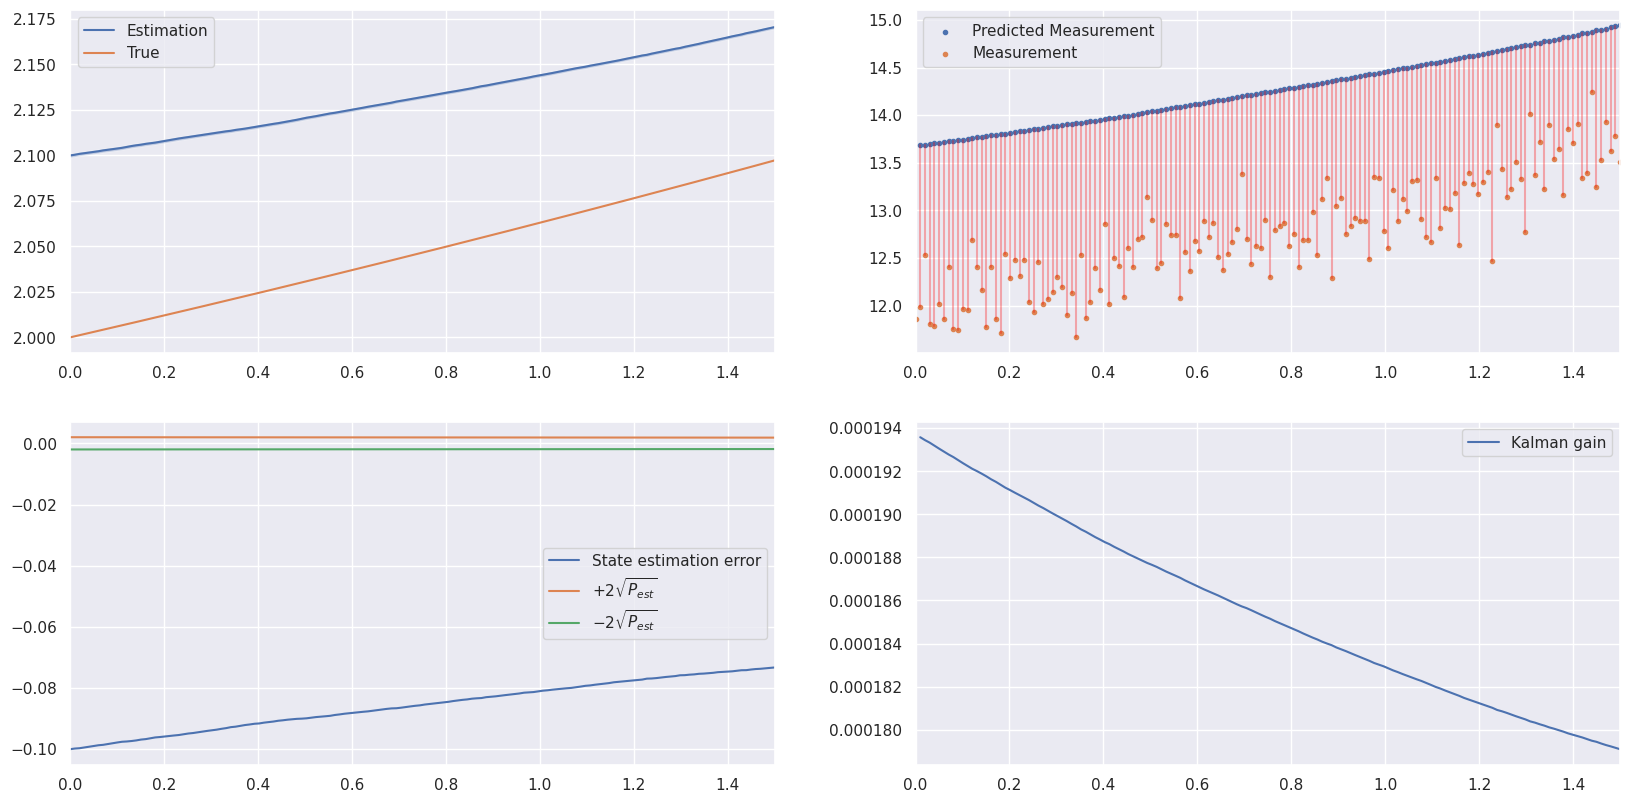

In [21]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=2.1, p0=0.000001)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

### Hard Non-linear

In [22]:
np.random.seed(SEED)

In [23]:
L = 100
dt = 1
N = int(L / dt)

T = np.linspace(0, L, N)

Initially, $Z_0 \sim \mathcal{N}(0.1, 5)$.

For $t=1..T$,
$$
\begin{array}{lcl}
    z_t &=& 0.5 z_{t-1} + \dfrac{25 z_{t-1}}{1 + z^2_{t-1}} + 8 \cos(1.2(t-1)) + w_{t-1} \\
    x_t &=& 0.05 z^2_t + v_t
\end{array}
$$

where $w_t, v_t$ are realizations of $W \sim \mathcal{N}(0, 10), V \sim \mathcal{N}(0, 1)$

In [24]:
# Process noise characterization
sw = 10

# Measurement noise characterization
sv = 1

# Process model
def process(z_prev):
    return 0.5 * z_prev + 25 * z_prev / (1 + z_prev ** 2)

# Control
def control(t):
    return 8 * np.cos(1.2 * (t - 1))

# Measurement model
def measurement(z_cur):
    return 0.05 * z_cur ** 2

In [25]:
Z = np.zeros(N)

# True system state without noise
Z[0] = randn() * np.sqrt(5) + 0.1
for t in range(1, N):
    Z[t] = process(Z[t - 1]) + control(t) + randn() * np.sqrt(sw)

# Measurement without noise
X_true = measurement(Z)
# Given observations
X = X_true + randn(N) * np.sqrt(sv)

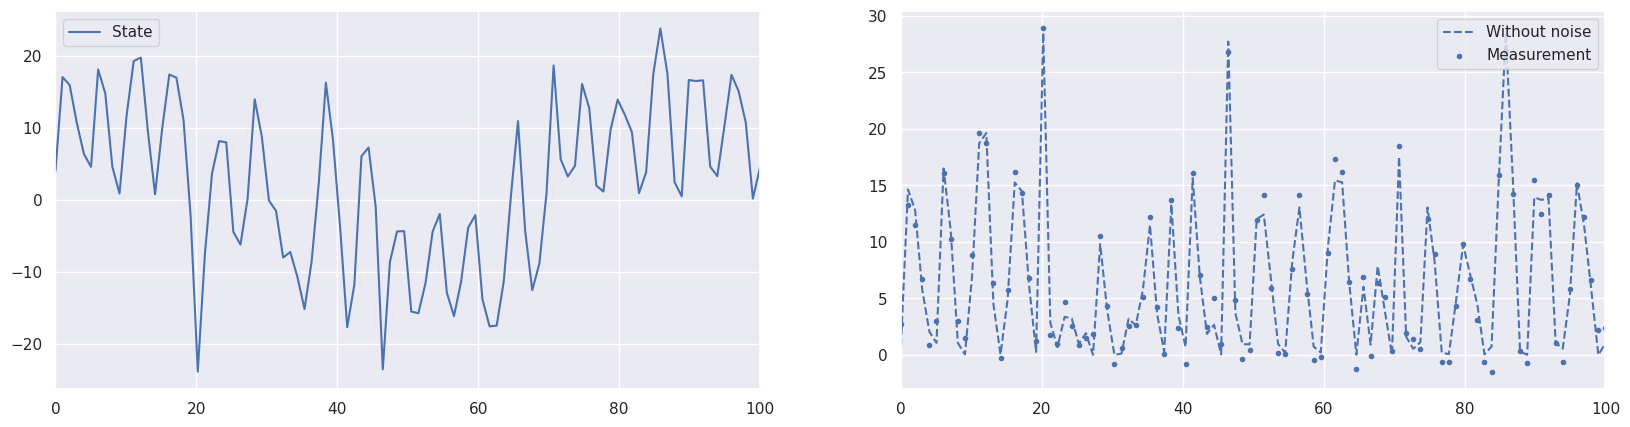

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

ax[0].plot(T, Z, label='State')
ax[0].set_xlim(0, L)
ax[0].legend()

ax[1].scatter(T, X, marker='.', label='Measurement')
ax[1].plot(T, X_true, linestyle='dashed', label='Without noise')
ax[1].set_xlim(0, L)
ax[1].legend()

plt.show()

Make the approximation
$$
\begin{array}{lcl}
    a[z_{t-1}] &=& 0.5 + \dfrac{25(1-z^2_{t-1})}{1 + z^2_{t-1}} \\
    c[z_t] &=& 0.1 z_t
\end{array}
$$

In [27]:
def d_process(z_prev):
    return 0.5 + 25 * (1 - z_prev ** 2) / (1 + z_prev ** 2)

def d_measurement(z_cur):
    return 0.1 * z_cur

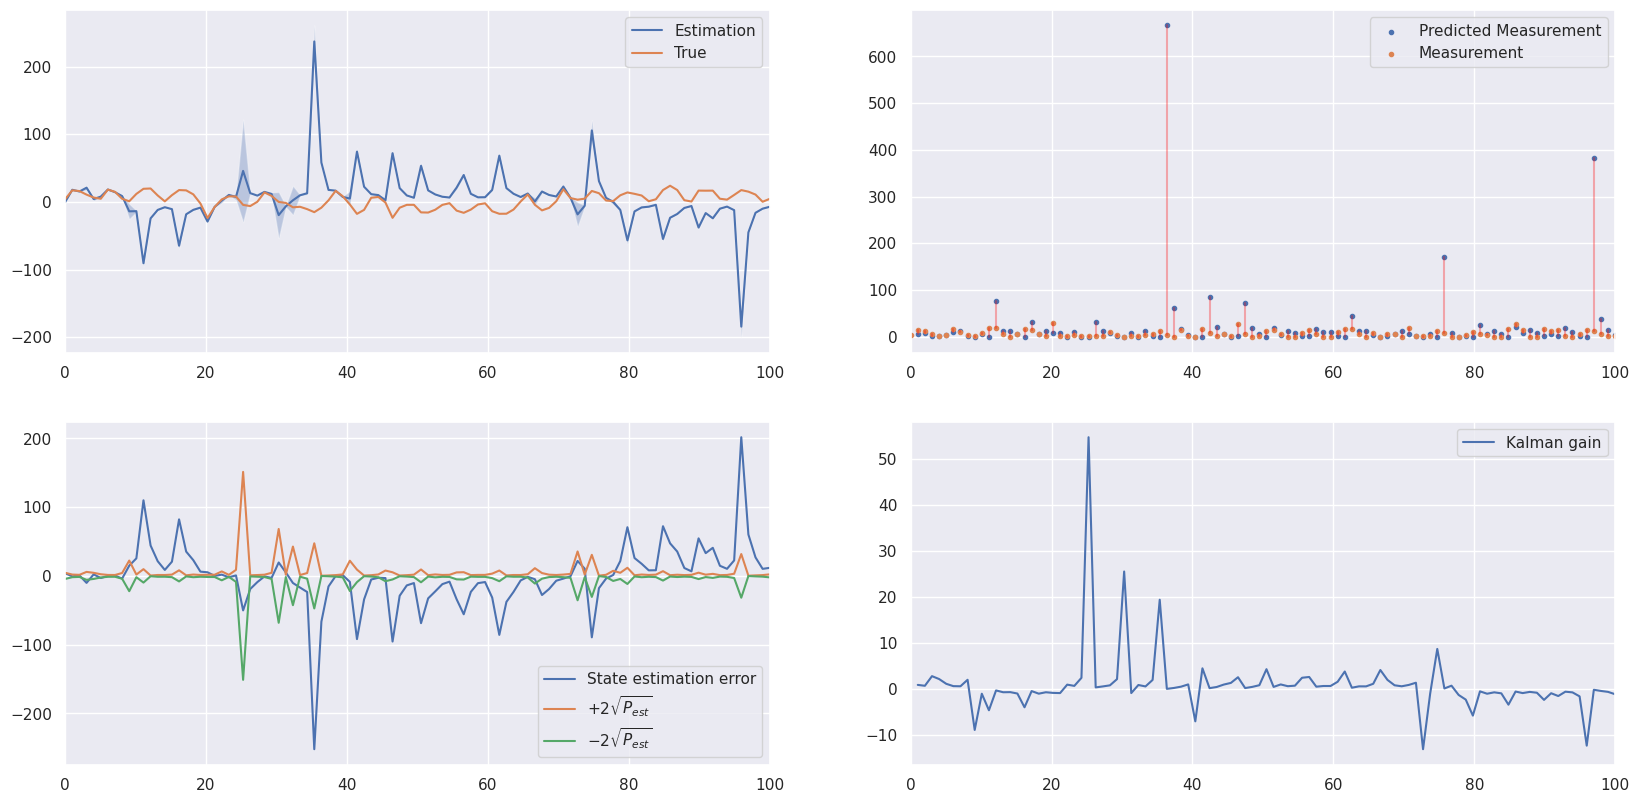

In [28]:
Z_pred, P_pred, Z_est, P_est, X_pred, gain = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=0.1, p0=5)
visualize_kalman_filter_1d(T, X, Z, Z_est, P_est, X_pred, gain)

## Particle Filter

In [29]:
np.random.seed(SEED)

In [30]:
n_particles = 100

z0 = 0.1
P0 = 5

def dynamic(particles, t):
    return process(particles) + control(t) + np.sqrt(sw) * randn(len(particles))

def noise_pdf(x):
    return 1. / np.sqrt(2 * np.pi * sv) * np.exp(-x ** 2 / (2 * sv))

In [31]:
Z_est, P_est = particle_filter(dynamic, measurement, noise_pdf, n_particles, X, z0, P0)

In [32]:
_, _, Z_est_kf, P_est_kf, _, _ = \
    extended_kalman_filter_1d(process, d_process, 
                              measurement, d_measurement, 
                              control,
                              sw, sv, X,
                              z0=0.1, p0=5)

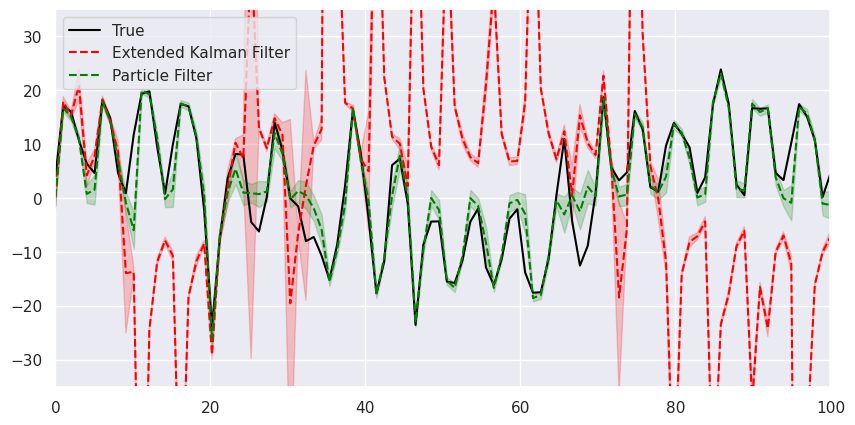

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

ax.plot(T, Z, color='black', label='True')

ax.fill_between(T,
                Z_est_kf + np.sqrt(P_est_kf),
                Z_est_kf - np.sqrt(P_est_kf),
                color='red', alpha=0.2)
ax.plot(T, Z_est_kf, color='red', linestyle='dashed', label='Extended Kalman Filter')

ax.fill_between(T,
                Z_est + np.sqrt(P_est),
                Z_est - np.sqrt(P_est),
                color='green', alpha=0.2)
ax.plot(T, Z_est, color='green', linestyle='dashed', label='Particle Filter')
ax.set_xlim(0, L)
ax.set_ylim(Z.min() - Z.std(), Z.max() + Z.std())
ax.legend()
plt.show()